In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

import time

%matplotlib inline

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

april16_1996 = '1996-04-16T00:00:00.000Z'
april16_1996 = astropy.time.Time(april16_1996).jd
print(april16_1996)

months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']


2450083.5
2450189.5


In [3]:
dates = []
distances = []
firstOrderFluxes = []
firstOrderFluxUncs = []
centralOrderFluxes = []
centralOrderFluxUncs = []

for i in range(1995,2025):
    try:
        datachunk = Table.read("./CELIAS-SEM/{0}_v4.day".format(str(i)[2:4]), format="ascii.no_header", guess=False, fast_reader=False, comment=";", data_start=0)
    except FileNotFoundError:
        continue
    datachunk.rename_column('col1', 'jd') 
    datachunk.rename_column('col13','distance')           # distance from Sun in km
    datachunk.rename_column('col15','firstOrderFlux')     # at distance given in column above. units photons cm^-2 s^-1
    datachunk.rename_column('col16','centralOrderFlux')   # at distance given in column above. units photons cm^-2 s^-1

    datachunk.rename_column('col4','ch1flux')
    datachunk.rename_column('col5','ch1unc')  
    datachunk.rename_column('col6','ch2flux')
    datachunk.rename_column('col7','ch2unc') 
    datachunk.rename_column('col8','ch3flux')
    datachunk.rename_column('col9','ch3unc')   


    dates.extend(datachunk['jd'])
    distances.extend(datachunk['distance'])
    firstOrderFluxes.extend(0.5*(datachunk['ch1flux'] + datachunk['ch3flux']))
    firstOrderFluxUncs.extend(0.5*np.sqrt(datachunk['ch1unc']**2 + datachunk['ch3unc']**2))
    centralOrderFluxes.extend(datachunk['ch2flux'])
    centralOrderFluxUncs.extend(datachunk['ch2unc'])
    
    #print(datachunk['jd'][0])
    #print('')
    #print(datachunk['jd'][-1])

dates = np.array(dates)
distances = np.array(distances)
firstOrderFluxes = np.array(firstOrderFluxes)
firstOrderFluxUncs = np.array(firstOrderFluxUncs)
centralOrderFluxes = np.array(centralOrderFluxes)
centralOrderFluxUncs = np.array(centralOrderFluxUncs)

#normalize by heliocentric distance---reference distance is 1 AU in km
normFactors = distances/(1.495978707e8)

firstOrderFluxes_norm = firstOrderFluxes*normFactors
firstOrderFluxUncs_norm = firstOrderFluxUncs*normFactors
centralOrderFluxes_norm = centralOrderFluxes*normFactors
centralOrderFluxUncs_norm = centralOrderFluxUncs*normFactors

#note that these dates start on jan 1, 1995 for some reason--all fluxes are zero till spacecraft starts taking data in december 1995
SEMdata = np.vstack((dates.T,distances.T,firstOrderFluxes.T,firstOrderFluxUncs.T,centralOrderFluxes.T,centralOrderFluxUncs.T)).T
print(np.shape(SEMdata))

SEMdata_norm = np.vstack((dates.T,firstOrderFluxes_norm.T,firstOrderFluxUncs_norm.T,centralOrderFluxes_norm.T,centralOrderFluxUncs_norm.T)).T
print(np.shape(SEMdata_norm))


missingObs = (firstOrderFluxes == 0.)
for colIdx in [2,3,4,5]:
    SEMdata[:,colIdx][missingObs] = np.nan
for colIdx in [1,2,3,4]:
    SEMdata_norm[:,colIdx][missingObs] = np.nan

#eliminate beginning of 1995 where nothing's happening (and the empty most recent entry of 2024)
dateMask = (dates >= 2450073) & (dates <= 2460349)

SEMdata = SEMdata[dateMask]
SEMdata_norm = SEMdata_norm[dateMask]
#print(np.shape(SEMdata))
#print(SEMdata[0])
#print(SEMdata[-1])

np.savetxt("./CELIAS-SEM/SEMDailyData.txt",SEMdata,fmt="%f", header="t_obs[JD] heliocentric_dist[km] firstOrderFlux[counts/s] firstOrderFluxUnc[counts/s] centralOrderFlux[counts/s] centralOrderFluxUnc[counts/s]")
np.savetxt("./CELIAS-SEM/SEMDailyData_norm.txt",SEMdata_norm,fmt="%f", header="t_obs[JD] firstOrderFlux[counts/s] firstOrderFluxUnc[counts/s] centralOrderFlux[counts/s] centralOrderFluxUnc[counts/s]")



(10632, 6)
(10632, 5)


In [4]:
print(np.median(SEMdata[:,2]))

nan


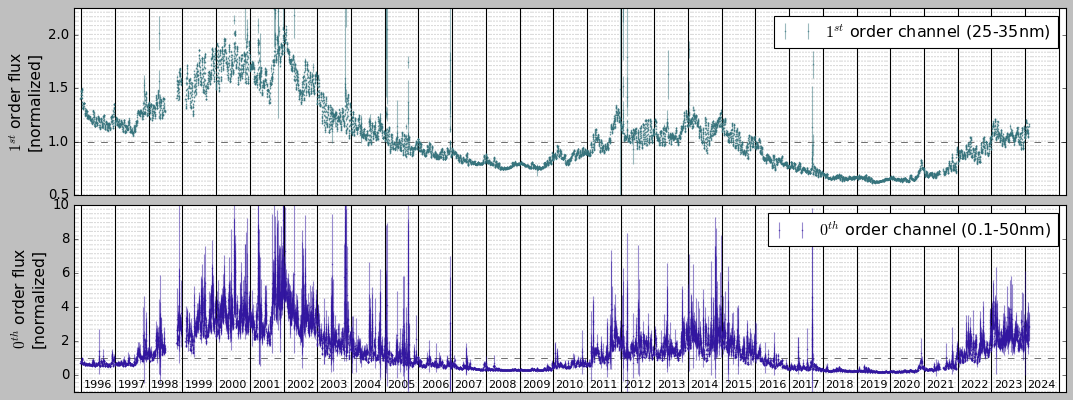

In [6]:
fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].errorbar(SEMdata[:,0], SEMdata[:,2]/np.median(SEMdata[:,2][~np.isnan(SEMdata[:,2])]), yerr=SEMdata[:,3]/np.median(SEMdata[:,2][~np.isnan(SEMdata[:,2])]), color='#36747d', marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='None',zorder=2,label=r"$1^{st}$ order channel (25-35nm)")
axes[1].errorbar(SEMdata[:,0], SEMdata[:,4]/np.median(SEMdata[:,4][~np.isnan(SEMdata[:,4])]), yerr=SEMdata[:,5]/np.median(SEMdata[:,4][~np.isnan(SEMdata[:,4])]), color='#3216a0', marker='.',capsize=0,elinewidth=1, ms=2, alpha=0.5,ls='None',zorder=2,label=r"$0^{th}$ order channel (0.1-50nm)")

for ax in axes:
    #ax.set_xlim(SEMdata[0,0] - 350, SEMdata[-1,0] + 350)
    ax.set_xlim(2450000, 2460750)

    ax.set_xticks([])
    for y in range(1995, 2025):
        jan1 = str(y) + '-01-01T00:00:00.000Z'
        jan1 = astropy.time.Time(jan1).jd
        ax.axvline(jan1, color='k', ls='-', lw=1, zorder=1)
            
        for m in range(2,13):
            m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
            m1 = astropy.time.Time(m1).jd
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    ax.legend(loc="upper right")

for y in range(1996, 2025):
    jan1 = str(y) + '-01-01T00:00:00.000Z'
    jan1 = astropy.time.Time(jan1).jd
    axes[1].text(jan1+25, -0.75, str(y), zorder=4,fontsize=10)

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
axes[0].axvline(jan1, color='k', ls='-', lw=1)
axes[1].axvline(jan1, color='k', ls='-', lw=1)
axes[0].axhline(1, color='k', ls = '--', lw=0.5, zorder=1)
axes[1].axhline(1, color='k', ls = '--', lw=0.5, zorder=1)


#axes[0].set_ylim(50,350)
#axes[1].set_ylim(0.,50000)
#axes[0].set_ylabel('first order flux'+'\n'+'[counts/s]',fontsize=14)
#axes[1].set_ylabel('central order flux'+'\n'+'[counts/s]',fontsize=14)

axes[0].set_ylim(0.5,2.25)
axes[1].set_ylim(-1,10)
axes[0].set_ylabel(r'$1^{st}$ order flux'+'\n'+'[normalized]',fontsize=14)
axes[1].set_ylabel(r'$0^{th}$ order flux'+'\n'+'[normalized]',fontsize=14)

#ax.set_ylabel(r'EUV flux at SOHO distance'+'\n'+'[photons cm${^-2}$ s$^{-1}$]',fontsize=14)
#axes[0].set_title('Mission-long Solar EUV Monitor Flux',fontsize=20)

#plt.show()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./SEM_missionlong.pdf",bbox_inches="tight")

In [5]:
# Compare SEM LC to VIRGO TSI LC
# Start 16 April 1996, the date at which SoHO was "fully commissioned for operations" per science.nasa.gov/mission/soho

pmodwrc_TSIdaily = Table.read("./VIRGO/pmodwrc_VIRGO_TSI_Daily_V8_20231211.txt", format="ascii.basic")
pmodwrc_TSIdaily['jd'] = 0.

for i in range(len(pmodwrc_TSIdaily)):
    tobs = pmodwrc_TSIdaily['utc_time'][i]
    pmodwrc_TSIdaily['jd'][i] = np.round(astropy.time.Time(tobs).jd,1)
    
#print(pmodwrc_TSIdaily)

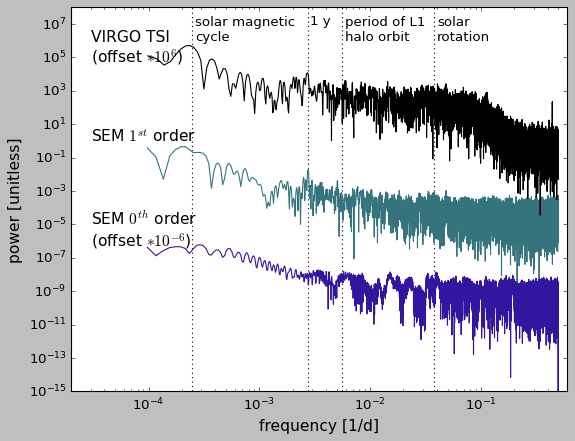

In [14]:
#cadence = 1 day
nonan = ~np.isnan(SEMdata[:,2])
nonan_norm = ~np.isnan(SEMdata_norm[:,1])

firstOrder_frequency, firstOrder_power = LombScargle(SEMdata[:,0][nonan],SEMdata[:,2][nonan],SEMdata[:,3][nonan]).autopower(minimum_frequency=(1./np.ptp(SEMdata[:,0][nonan])), maximum_frequency=(1./2.))
centralOrder_frequency, centralOrder_power = LombScargle(SEMdata[:,0][nonan],SEMdata[:,4][nonan],SEMdata[:,5][nonan]).autopower(minimum_frequency=(1./np.ptp(SEMdata[:,0][nonan])), maximum_frequency=(1./2.))

firstOrdernorm_frequency, firstOrdernorm_power = LombScargle(SEMdata_norm[:,0][nonan_norm],SEMdata_norm[:,1][nonan_norm],SEMdata_norm[:,2][nonan_norm]).autopower(minimum_frequency=(1./np.ptp(SEMdata_norm[:,0][nonan_norm])), maximum_frequency=(1./2.))
centralOrdernorm_frequency, centralOrdernorm_power = LombScargle(SEMdata_norm[:,0][nonan_norm],SEMdata_norm[:,3][nonan_norm],SEMdata_norm[:,4][nonan_norm]).autopower(minimum_frequency=(1./np.ptp(SEMdata_norm[:,0][nonan_norm])), maximum_frequency=(1./2.))

TSI_nonans = ~np.isnan(pmodwrc_TSIdaily['TSI_virgo_fused_new'])
TSI_frequency, TSI_power = LombScargle(pmodwrc_TSIdaily['jd'][TSI_nonans],pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSI_nonans],pmodwrc_TSIdaily['TSI_virgo_fused_unc'][TSI_nonans]).autopower(minimum_frequency=(1./np.ptp(pmodwrc_TSIdaily['jd'])), maximum_frequency=(1./2.))
"""

firstOrder_frequency, firstOrder_power = LombScargle(SEMdata[:,0][nonan],SEMdata[:,2][nonan]).autopower(minimum_frequency=(1./np.ptp(SEMdata[:,0][nonan])), maximum_frequency=(1./2.))
centralOrder_frequency, centralOrder_power = LombScargle(SEMdata[:,0][nonan],SEMdata[:,4][nonan]).autopower(minimum_frequency=(1./np.ptp(SEMdata[:,0][nonan])), maximum_frequency=(1./2.))

firstOrdernorm_frequency, firstOrdernorm_power = LombScargle(SEMdata_norm[:,0][nonan_norm],SEMdata_norm[:,1][nonan_norm]).autopower(minimum_frequency=(1./np.ptp(SEMdata_norm[:,0][nonan_norm])), maximum_frequency=(1./2.))
centralOrdernorm_frequency, centralOrdernorm_power = LombScargle(SEMdata_norm[:,0][nonan_norm],SEMdata_norm[:,3][nonan_norm]).autopower(minimum_frequency=(1./np.ptp(SEMdata_norm[:,0][nonan_norm])), maximum_frequency=(1./2.))

TSI_nonans = ~np.isnan(pmodwrc_TSIdaily['TSI_virgo_fused_new'])
TSI_frequency, TSI_power = LombScargle(pmodwrc_TSIdaily['jd'][TSI_nonans],pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSI_nonans]).autopower(minimum_frequency=(1./np.ptp(pmodwrc_TSIdaily['jd'])), maximum_frequency=(1./2.))
"""
fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
ax.axvline(1./(11*365.),color='k',ls=':',zorder=1) #magnetic cycle

ax.text(1.05/26.24, 1.e6, 'solar'+'\n'+'rotation',fontsize=12)
ax.text(1.05/178., 1.e6, 'period of L1'+'\n'+'halo orbit',fontsize=12)
ax.text(1.05/365., 1.e7, '1 y',fontsize=12)
ax.text(1.05/(365*11), 1.e6, 'solar magnetic'+'\n'+'cycle',fontsize=12)

ax.plot(firstOrder_frequency, firstOrder_power, ls='-',color='#36747d',zorder=1)
ax.plot(centralOrder_frequency, centralOrder_power*1.e-6, ls='-',color='#3216a0',zorder=1)

#ax.plot(firstOrdernorm_frequency, firstOrdernorm_power, 'g-',alpha=1,zorder=2)
#ax.plot(centralOrdernorm_frequency, centralOrdernorm_power*1.e-6, 'y-',alpha=1,zorder=2)

ax.plot(TSI_frequency, TSI_power*1.e6, 'k-')
ax.text(3.e-5, 5.e4, "VIRGO TSI"+"\n"+r"(offset $*10^6$)", fontsize=14)
ax.text(3.e-5, 1.e0, r"SEM $1^{st}$ order", fontsize=14)
ax.text(3.e-5, 5.e-7, r"SEM $0^{th}$ order"+"\n"+r"(offset $*10^{-6}$)", fontsize=14)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("frequency [1/d]", fontsize=14)
ax.set_ylabel("power [unitless]", fontsize=14)

ax.set_xlim(2.e-5, 6.e-1)
ax.set_ylim(1.e-15, 1.e8)
#plt.show()
plt.savefig("VIRGO_SEM_LSperiodogram.pdf",bbox_inches="tight")
    

In [6]:
#consider same date range---post SoHO fully commissioned (April 16, 1996), pre end of VIRGO TSI obs
TSIdatemask = (pmodwrc_TSIdaily['jd'] > 2450189.5)
SEMdatemask = (SEMdata[:,0] > 2450189.5) & (SEMdata[:,0] <= pmodwrc_TSIdaily['jd'][-1])

cycleCutoff = 2454500.

TSIdatemask23 = (pmodwrc_TSIdaily['jd'] > 2450189.5) & (pmodwrc_TSIdaily['jd'] <= cycleCutoff)
SEMdatemask23 = (SEMdata[:,0] > 2450189.5) & (SEMdata[:,0] <= cycleCutoff)

TSIdatemask24 = (pmodwrc_TSIdaily['jd'] > cycleCutoff) 
SEMdatemask24 = (SEMdata[:,0] > cycleCutoff) & (SEMdata[:,0] <= pmodwrc_TSIdaily['jd'][-1])


qualityMask23 = (pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask23] > 0.)
print(len(pmodwrc_TSIdaily[TSIdatemask]))
print(len(SEMdata[SEMdatemask]))
print(len(pmodwrc_TSIdaily[TSIdatemask23]))
print(len(SEMdata[SEMdatemask23]))
print(len(pmodwrc_TSIdaily[TSIdatemask24]))
print(len(SEMdata[SEMdatemask24]))

10074
10074
4311
4311
5763
5763


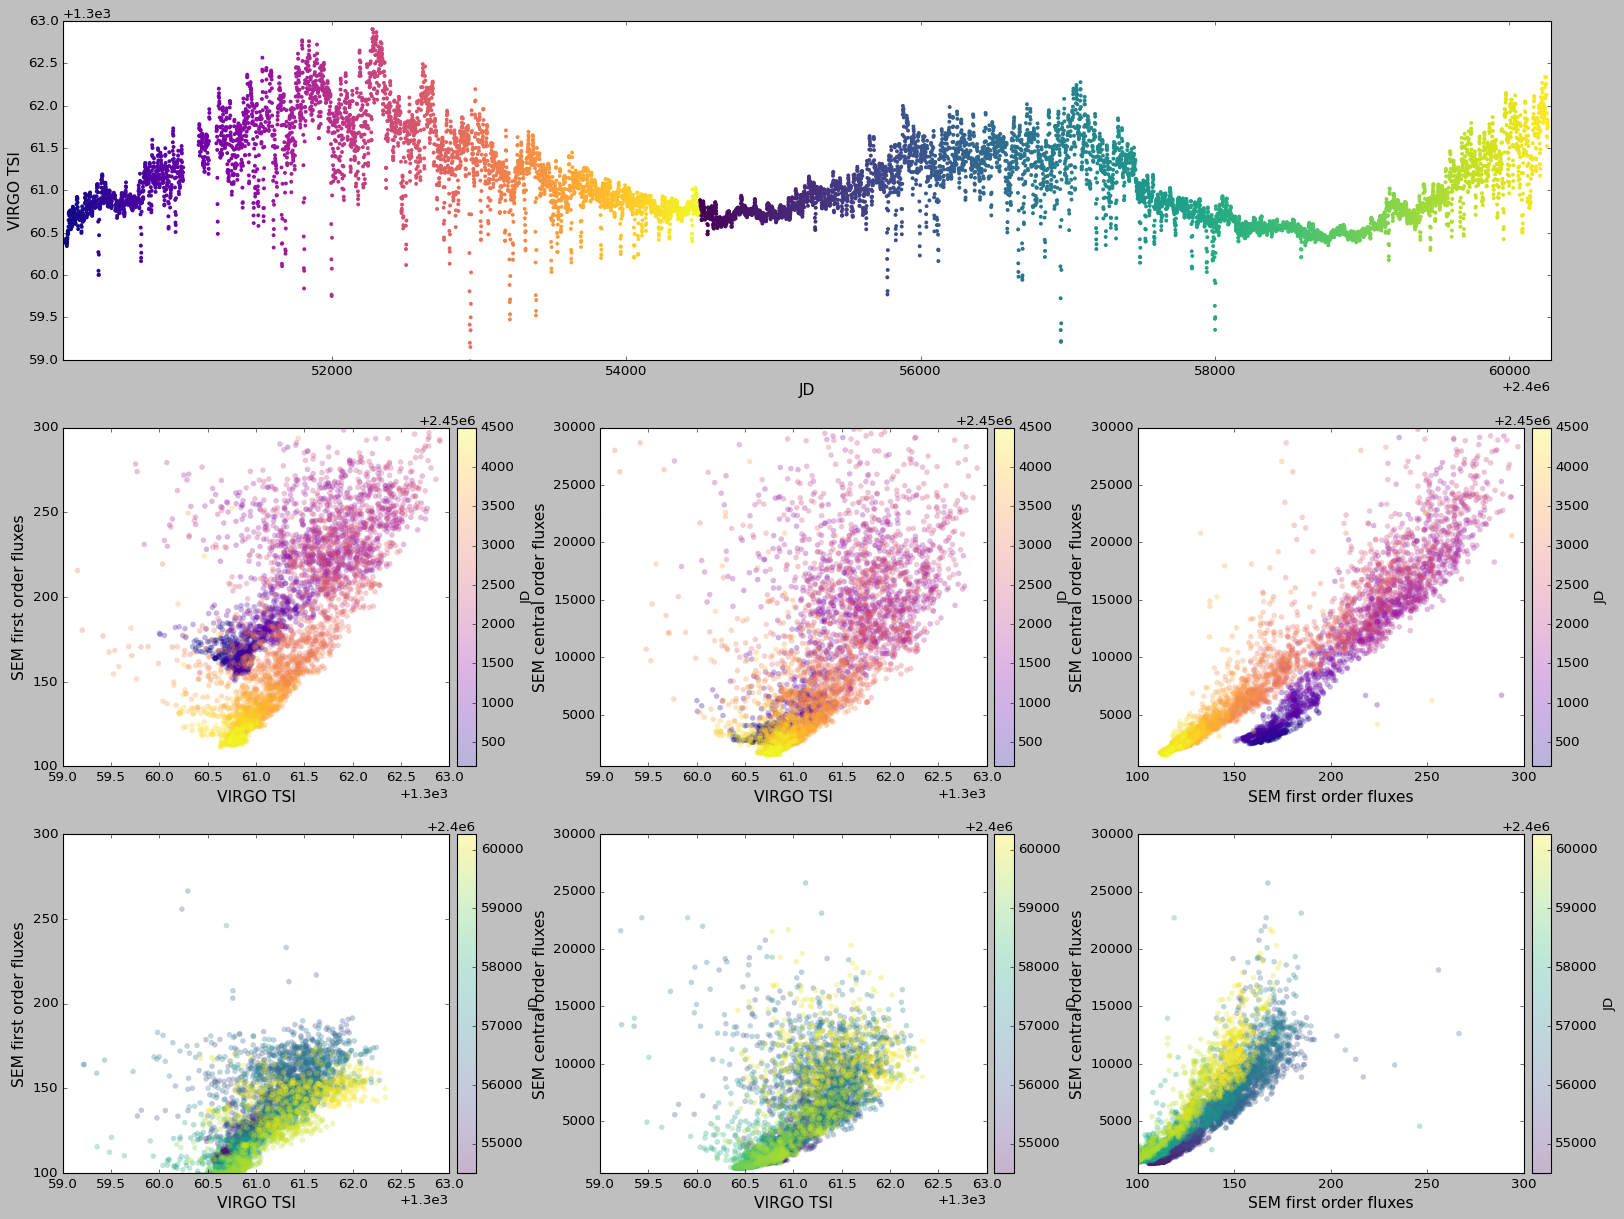

In [45]:
VIRGOnorm = pmodwrc_TSIdaily['TSI_virgo_fused_new']/np.median(pmodwrc_TSIdaily['TSI_virgo_fused_new'])
SEM1norm = SEMdata[:,2]/np.median(SEMdata[:,2][~np.isnan(SEMdata[:,2])])
SEM0norm = SEMdata[:,4]/np.median(SEMdata[:,4][~np.isnan(SEMdata[:,4])])

fig = plt.figure(figsize=(24,18))
gs = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
LCax = fig.add_subplot(gs[0,:])

ax0 = fig.add_subplot(gs[1, 0])  
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 2])

ax3 = fig.add_subplot(gs[2, 0])  
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[2, 2])
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

LCax.scatter(pmodwrc_TSIdaily['jd'][TSIdatemask23], pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask23], c=pmodwrc_TSIdaily['jd'][TSIdatemask23], cmap='plasma', marker='.', s=50, edgecolor='None')
LCax.scatter(pmodwrc_TSIdaily['jd'][TSIdatemask24], pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask24], c=pmodwrc_TSIdaily['jd'][TSIdatemask24], cmap='viridis', marker='.', s=50, edgecolor='None')

cs0 = axes[0].scatter(pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask23], SEMdata[:,2][SEMdatemask23], c=SEMdata[:,0][SEMdatemask23], cmap='plasma', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[0].set_xlabel("VIRGO TSI",fontsize=14)
axes[0].set_ylabel("SEM first order fluxes",fontsize=14)

cs1 = axes[1].scatter(pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask23], SEMdata[:,4][SEMdatemask23], c=SEMdata[:,0][SEMdatemask23], cmap='plasma', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[1].set_xlabel("VIRGO TSI",fontsize=14)
axes[1].set_ylabel("SEM central order fluxes",fontsize=14)

cs2 = axes[2].scatter(SEMdata[:,2][SEMdatemask23], SEMdata[:,4][SEMdatemask23],  c=SEMdata[:,0][SEMdatemask23], cmap='plasma', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[2].set_xlabel("SEM first order fluxes",fontsize=14)
axes[2].set_ylabel("SEM central order fluxes",fontsize=14)

cs3 = axes[3].scatter(pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask24], SEMdata[:,2][SEMdatemask24], c=SEMdata[:,0][SEMdatemask24], cmap='viridis', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[3].set_xlabel("VIRGO TSI",fontsize=14)
axes[3].set_ylabel("SEM first order fluxes",fontsize=14)

cs4 = axes[4].scatter(pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask24], SEMdata[:,4][SEMdatemask24], c=SEMdata[:,0][SEMdatemask24], cmap='viridis', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[4].set_xlabel("VIRGO TSI",fontsize=14)
axes[4].set_ylabel("SEM central order fluxes",fontsize=14)

cs5 = axes[5].scatter(SEMdata[:,2][SEMdatemask24], SEMdata[:,4][SEMdatemask24],  c=SEMdata[:,0][SEMdatemask24], cmap='viridis', marker='.', s=100, edgecolor='None',alpha=0.3)
axes[5].set_xlabel("SEM first order fluxes",fontsize=14)
axes[5].set_ylabel("SEM central order fluxes",fontsize=14)

cs = [cs0, cs1, cs2, cs3, cs4, cs5]
for i, ax in enumerate(axes):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="2%")
    fig.add_axes(cax)
    fig.colorbar(cs[i], cax=cax,label="JD")

LCax.set_xlim(pmodwrc_TSIdaily['jd'][TSIdatemask][0] - 20, pmodwrc_TSIdaily['jd'][TSIdatemask][-1] + 20)
LCax.set_ylim(1359, 1363)
LCax.set_xlabel('JD',fontsize=14)
LCax.set_ylabel('VIRGO TSI',fontsize=14)

for ax in [ax0, ax3]:
    ax.set_xlim(1359,1363)
    ax.set_ylim(100,300.)

for ax in [ax1, ax4]:
    ax.set_xlim(1359,1363)
    ax.set_ylim(500,30000)

for ax in [ax2, ax5]:
    ax.set_xlim(100,300.)
    ax.set_ylim(500,30000)

plt.subplots_adjust(wspace = 0.3)
#plt.show()
plt.savefig("VIRGO_SEM_fluxcorr.pdf",bbox_inches="tight")

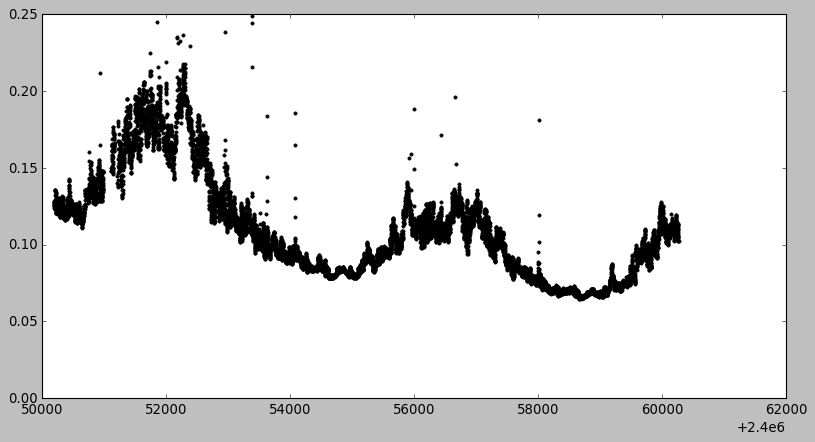

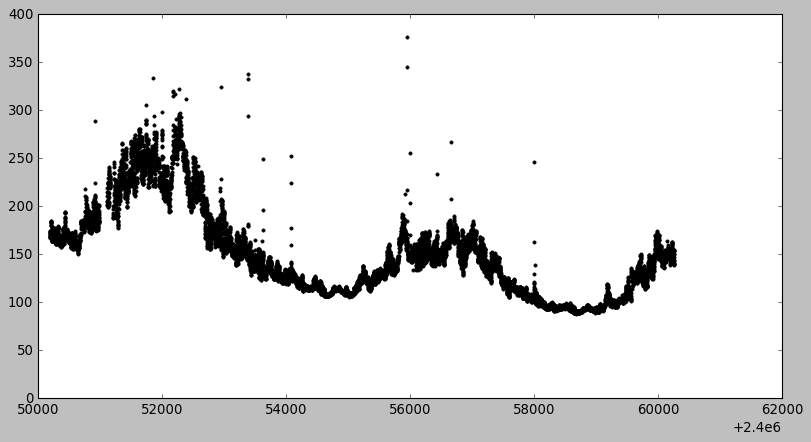

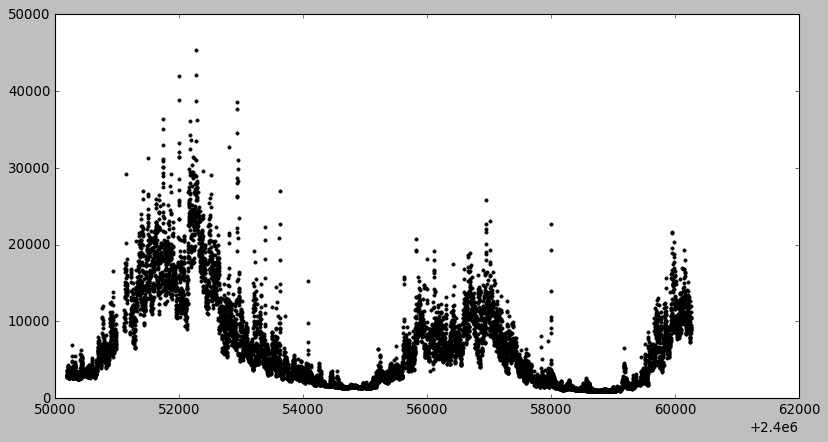

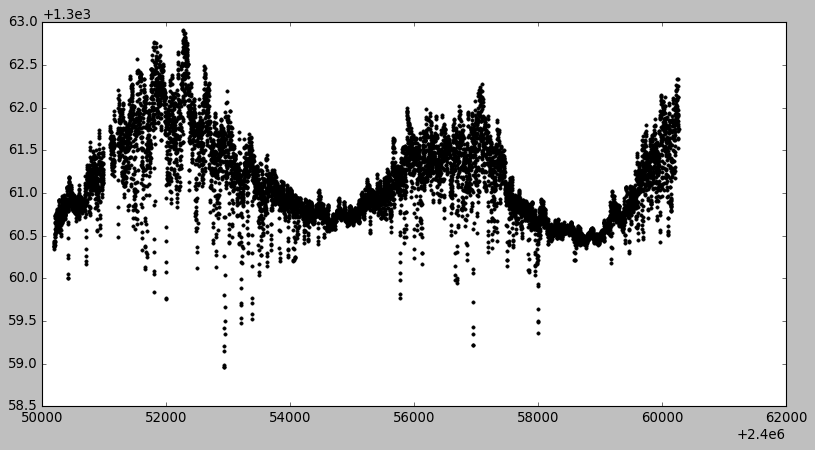

In [23]:
ratio = SEMdata[:,2][SEMdatemask23 | SEMdatemask24]/pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask23 | TSIdatemask24]

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(pmodwrc_TSIdaily['jd'][TSIdatemask23| TSIdatemask24], ratio, 'k.')
ax.set_ylim(0,0.25)

plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(pmodwrc_TSIdaily['jd'][TSIdatemask23| TSIdatemask24], SEMdata[:,2][SEMdatemask23 | SEMdatemask24], 'k.')
ax.set_ylim(0,400)

plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(pmodwrc_TSIdaily['jd'][TSIdatemask23| TSIdatemask24], SEMdata[:,4][SEMdatemask23 | SEMdatemask24], 'k.')


plt.show()

ig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(pmodwrc_TSIdaily['jd'][TSIdatemask23| TSIdatemask24], pmodwrc_TSIdaily['TSI_virgo_fused_new'][TSIdatemask23 | TSIdatemask24], 'k.')
#ax.set_ylim(0,1000)

plt.show()